In [2]:
import matplotlib
import matplotlib.pyplot as plt
import random
import os
import seaborn as sns
import pystan
# import corner
from scipy.interpolate import interp1d
from collections import OrderedDict
import pandas as pd
import tqdm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/maxisi/custompy3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# make plots to fit the LaTex column size but rescale them for ease of display here
scale_factor = 4

fig_width_pt = scale_factor*246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_ratio = 0.5*(np.sqrt(5)-1.0)/2.0         # Plot aspect ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height =fig_width*fig_ratio       # height in inches
fig_size = [fig_width, fig_height]

# LaTex text font sizse in points (rescaled as above)
fs = scale_factor*8  # general
lfs = 0.9*fs  # legend
tfs0 = 0.8*fs  # ax0 ticks
tfs12 = 0.6*fs # ax1/2 ticks

mplparams = {
    'text.usetex': True,  # use LaTeX for all text
    'axes.linewidth': 1,  # set axes linewidths to 0.5
    'axes.grid': False,  # add a grid
    'axes.labelweight': 'normal',
    'font.size': fs,
    'font.serif': 'Computer Modern Roman',
    'xtick.labelsize': fs,
    'ytick.labelsize': fs,
}
matplotlib.rcParams.update(mplparams)

# sns.set(font_scale=1.5)
sns.axes_style("white")
sns.set_style("ticks", {'font.family': 'serif'})

# Functions

In [4]:
def snr_pdf(snr):
    """Distribution of SNRs, i.e. PDF(snr)"""
    return 3.*12.**3/snr**4

def gaussian(x, mean, sigma):
    """Gaussian PDF(x | mu, sigma)"""
    return 1./sqrt(2.*pi)/sigma*exp(-(x-mean)**2/2./sigma**2)

def MakeSNRPopulation(Ndet, seed, snr_min=12., snr_max=1000.):
    """Draw `Ndet` SNRs from SNR PDF using rejection sampling.
    """
    np.random.seed(seed)
    snr_sample_list = []
    for i in range(Ndet):
        snr_sample = 10000.
        # rejection sampling
        while snr_pdf(snr_sample) < np.random.uniform(0, 0.25):
            snr_sample = np.random.uniform(snr_min, snr_max)
        snr_sample_list.append(snr_sample)
    return np.array(snr_sample_list)

In [5]:
def MakePhiPopulation(Phis_inj, q, eta, Ndet, sigma_refs=[0.1, 0.5, 0.25], snr_ref=25., scale_factor=1., **kwargs):
    # get true values for each phi_i
    phi0_inj, phi1_inj, phi2_inj = Phis_inj
    
    # get the true measured values (non-diagnoal transformation)
    phi0m = phi0_inj + np.power(eta, 3)*phi1_inj + 20*(0.55-q)*phi2_inj
    phi1m = np.power(eta,3)*phi0_inj + phi1_inj  
    phi2m = np.power(eta,3)*phi0_inj + np.power(eta,3)*phi1_inj + phi2_inj
    Phis_inj_m =[phi0m, phi1m, phi2m]
    
    # get population of SNRs
    SNR = MakeSNRPopulation(Ndet, 1234, **kwargs)
    # create measured standard deviations for each phi
    sigmas_m = [sigma_ref*snr_ref/SNR for sigma_ref in sigma_refs]
    # create measured mean for each phi
    sigmas_m_scatter = [scale_factor*sm for sm in sigmas_m]
    phis_m = [np.random.normal(pm, sms) for pm,sms in zip(Phis_inj_m, sigmas_m_scatter)]
    return phis_m, sigmas_m

# Simulate

In [6]:
Ndet = 100
Phis_inj = [0, 0, 0.1]

nparam = len(Phis_inj)

q = np.random.uniform(0.1, 1, Ndet)
eta = q/(1+q)/(1+q)

Phis_m, sigma_m = MakePhiPopulation(Phis_inj, q, eta, Ndet)

In [7]:
# plt.figure(figsize=np.array(fig_size)*0.8)
# for i, pm in enumerate(Phis_m):
#     plt.hist(pm, alpha=0.5, label=str(i))
# plt.legend()
# plt.show()

In [8]:
model_GR = pystan.StanModel(file='GR_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1eb02828cfd460f48b53a743a764f9a0 NOW.
/Users/maxisi/custompy3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/0x/37jrlqfs6sv4sr6n5bfc_p540000gq/T/tmp7mwigv1f/stanfit4anon_model_1eb02828cfd460f48b53a743a764f9a0_4414672265676500721.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [9]:
GR_data_samples = []
for i in range(nparam):
    print("Fitting %i/%i" % (i+1, nparam))
    Data = {
        'ndet': Ndet,
        'muobs': Phis_m[i],
        'sigma_muobs': sigma_m[i]
    }
    Fit = model_GR.sampling(data=Data, iter=4000)#, thin=100, control={"adapt_delta" : 0.95,"max_treedepth":15})
    GR_data_samples.append(Fit.extract(permuted=True))

Fitting 1/3
Fitting 2/3
Fitting 3/3


# Plot

In [10]:
from bounded_1d_kde import Bounded_1d_kde

In [11]:
def ComputeSymCI(samples, ci=0.9):
    """ Find HPD at target.
    """
    lo = np.percentile(samples, 100.0 * (1-ci)*0.5)
    hi = np.percentile(samples, 100.0 * (1-(1-ci)*0.5))
    return hi - lo

def ComputeHPD(Samples, p=0.9):
    """ Find p-% HPD.
    """
    NewSamples = sort(Samples)
    n = len(Samples)
    m = int((1-n)*p)
    i = np.argmin(NewSamples[-m:] - NewSamples[:m])
    return (NewSamples[i], NewSamples[i+int(n*p)])

def ComputeHPD2(Samples, target=0, dp=0.00005, tol=0.001):
    """ Find HPD at target.
    """
    ps = np.arange(dp, 1, dp)
    for p in ps:
        try:
            lo, hi = ComputeHPD(Samples, p)
            lo_dist = lo - target
            hi_dist = hi - target
            if np.abs(hi_dist) < tol or np.abs(lo_dist) < tol:
                break
        except IndexError:
            pass
        except ValueError:
            pass
    if p == ps[-1]:
        # try with a worse tolerance
        return ComputeHPD2(Samples, target=0, dp=0.0005, tol=tol*2)
    return p, lo_dist, hi_dist

0 0.7368572499654112 0.1911138096317984 (0.54345, -0.0006591004677697528, 0.08415020467685963)
1 0.4460443991957026 0.24524701554768752 (0.3267, -0.0008340050222624875, 0.0626177573872215)
2 2.2375194850622417 0.12008236137918399 (0.9721500000000001, 0.0005707817071472993, 0.16125444363688318)


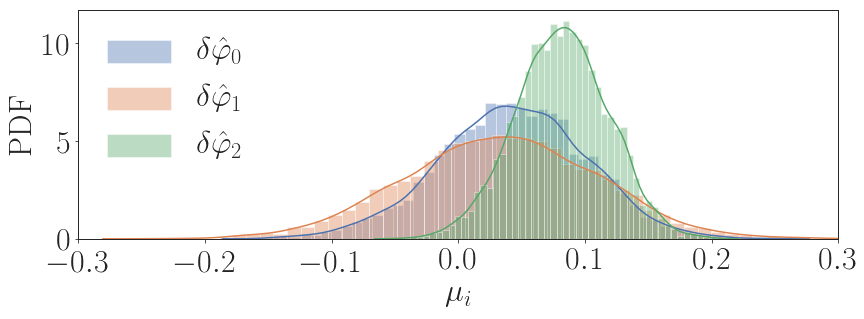

0 12.55193108722239 0.14788692219525912 0.6290982044297434 (0.755, 0.5116370194264095, 0.6157866058728817)
1 1.7942029583876908 0.409264880841699 0.3924540368726287 (0.90575, 0.0003078817456809077, 0.39602491413465357)
2 1.4719044695472057 0.15868120009875472 0.14144521236534785 (0.0036500000000000005, 0.0006222554166182778, 0.0008752086369096257)


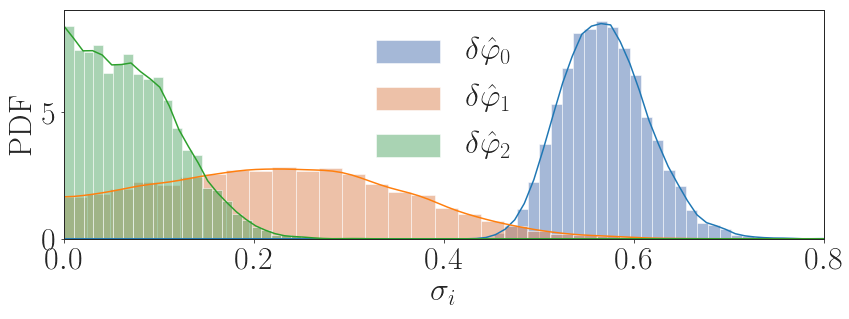

In [17]:
colors = sns.color_palette('deep', nparam)

# plot mu
plt.figure(figsize=fig_size)
for i, samples in enumerate(GR_data_samples):
    sns.distplot(samples['mu'], label=r'$\delta\hat{\varphi}_%i$' % i, color=colors[i])
    # compute stats
    zscore = np.mean(samples['mu']) / np.std(samples['mu'])
    muCI = ComputeSymCI(samples['mu'])
    hpd = ComputeHPD2(samples['mu'])
    print(i, zscore, muCI, hpd)
plt.legend(frameon=False, loc='upper left')
plt.xlim(-0.3, 0.3)
plt.xlabel('$\mu_i$')
plt.ylabel('PDF')
plt.savefig("../Paper/mu-GRiswrong.pdf",bbox_inches='tight')
plt.show()

# plot sigma
plt.figure(figsize=fig_size)
for i, samples in enumerate(GR_data_samples):
#     sns.distplot(samples['sigma'], label=r'$\delta\varphi_%i$' % i, bins=30, kde=False, norm_hist=False)
    plt.hist(samples['sigma'], bins=30, density=True, alpha=0.5, color=colors[i], label=r'$\delta\hat{\varphi}_%i$' % i)
    sigma_kde = Bounded_1d_kde(samples['sigma'], xlow=0)
    sigma_vec = np.linspace(0, 1, 100)
    plt.plot(sigma_vec, sigma_kde.evaluate(sigma_vec))#, label=r'$\delta\varphi_%i$' % i)
    plt.xlim(0, 1)
    # compute stats
    zscore = np.mean(samples['sigma']) / np.std(samples['sigma'])
    sigmaCI = ComputeSymCI(samples['sigma'])
    hpd = ComputeHPD2(samples['sigma'])
    sigma_90 = np.percentile(samples['sigma'], 90)
    print(i, zscore, sigmaCI, sigma_90, hpd)
plt.legend(frameon=False)#, loc='upper right')
plt.xlim(0, 0.8)
plt.xlabel('$\sigma_i$')
plt.ylabel('PDF')
plt.savefig("../Paper/sigma-GRiswrong.pdf",bbox_inches='tight')
plt.show()

In [13]:
1./len(samples['sigma'])

0.000125

## Individual plots

0


/Users/maxisi/custompy3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  """


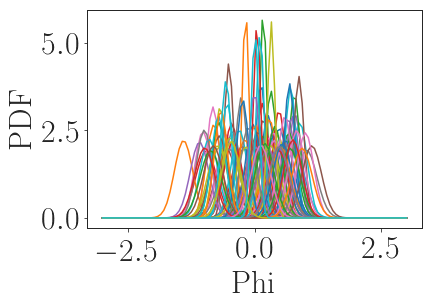

1


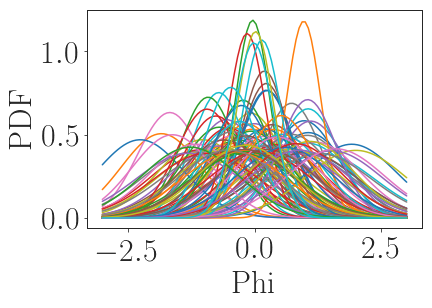

2


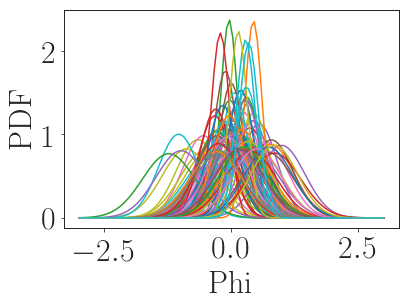

In [14]:
for i in [0,1,2]:
    print(i)
    for j in range(Ndet):
        x = np.linspace(-3,3, 100)
        plt.plot(x,mlab.normpdf(x, Phis_m[i][j], sigma_m[i][j]))
    plt.xlabel('Phi')
    plt.ylabel('PDF')
    plt.show()